In [2]:
import geopandas as gpd

# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(r"C:\Users\vibhu\Downloads\LS_mask\UKCP_18_09\Bias Corrected Imputation\Rainfall_1980-2010\Imputing Points\Points\UK_PPT_DEM_12km_impute.shp")

# Filter the GeoDataFrame to include only coastal points
coastal_points = gdf[gdf['classifica'] == 'coastal']

# Extract the required columns
coastal_data = coastal_points[['latitude', 'longitude', 'value']]

# Save the extracted data to a CSV file
coastal_data.to_csv('coastal_points.csv', index=False)


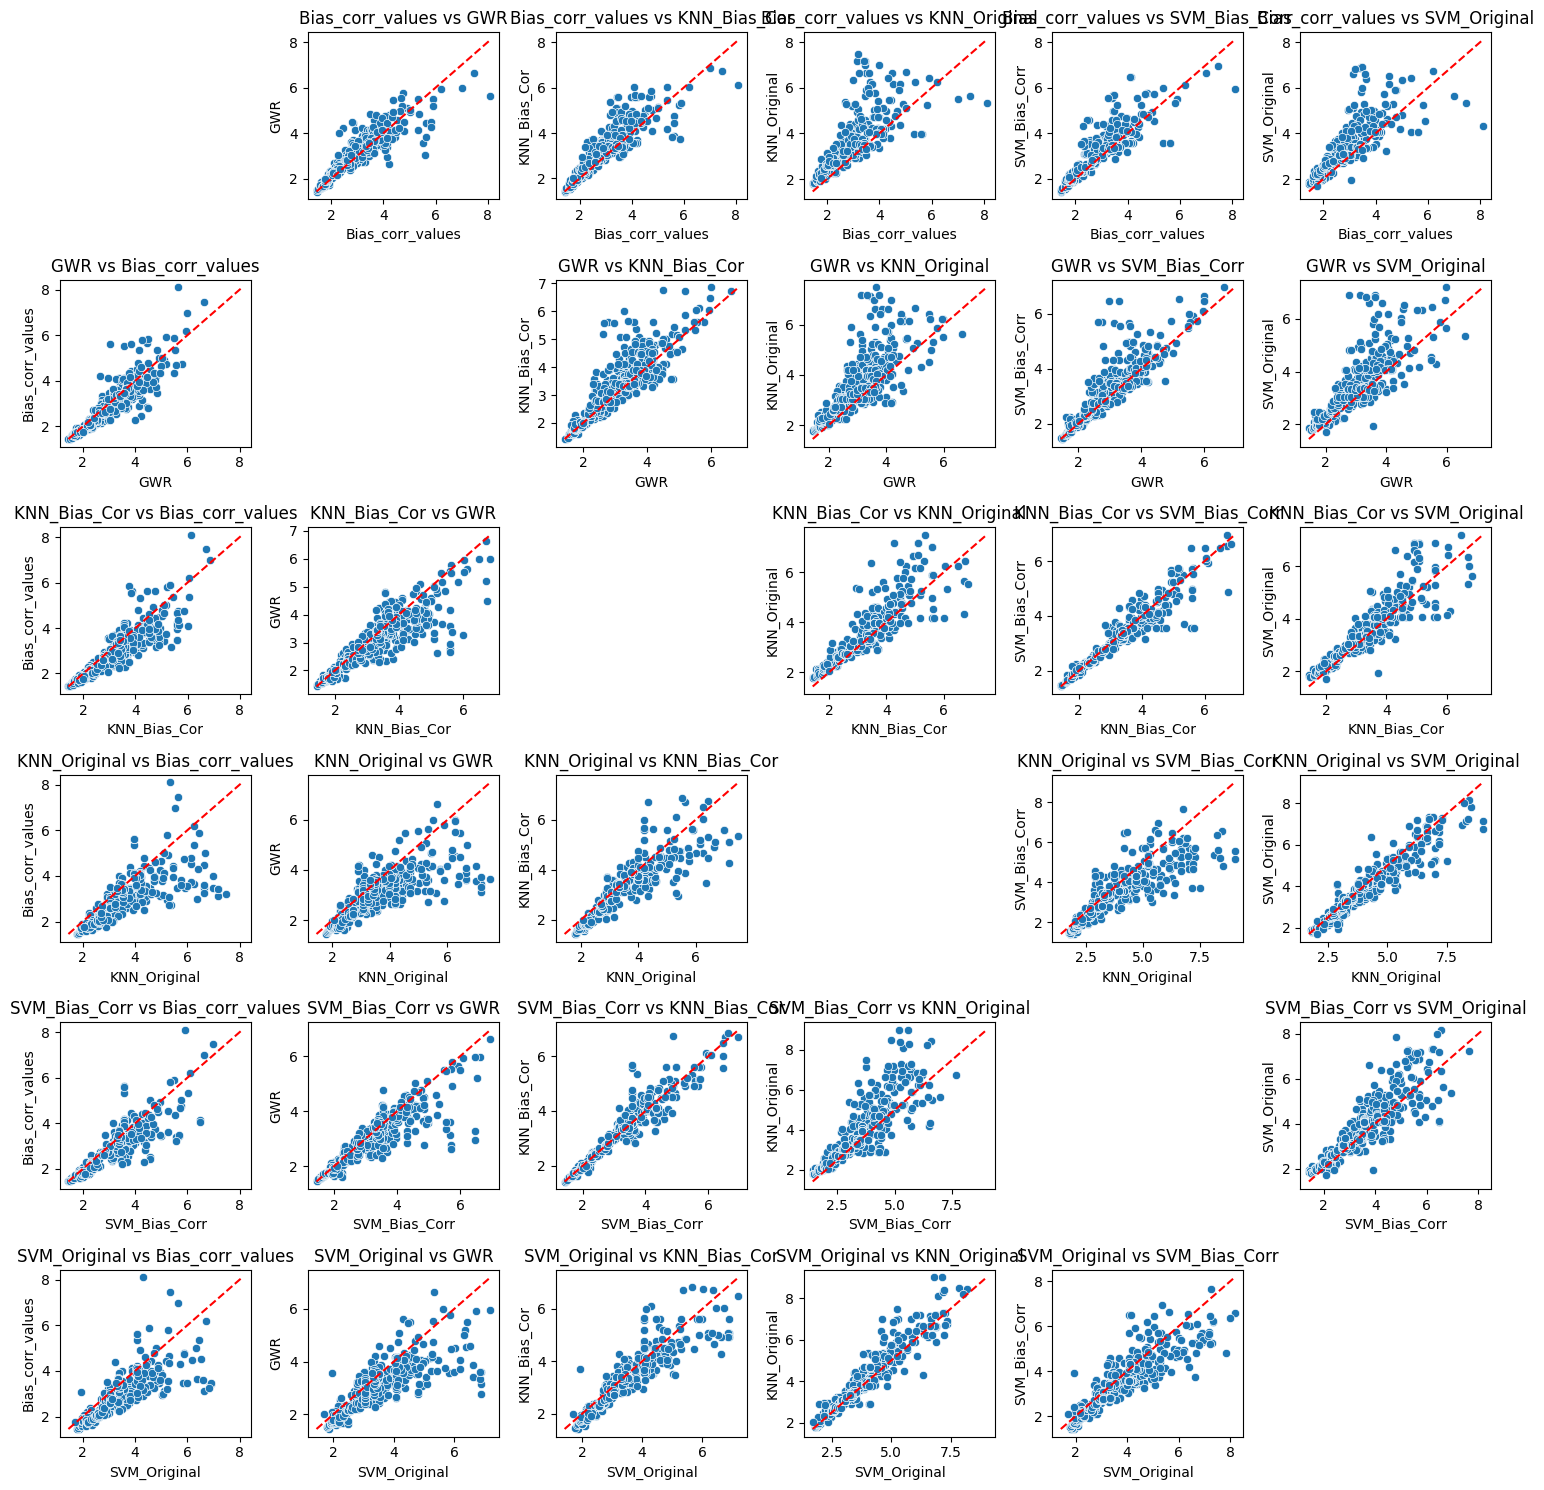

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Define file paths and corresponding method names
file_paths = [
    ('SVM_original.csv', 'SVM_Original'),
    ('SVM_Bias_corr.csv', 'SVM_Bias_Corr'),
    ('KNN_Bias_corr.csv', 'KNN_Bias_Cor'),
    ('KNN_original.csv', 'KNN_Original'),
    ('coastal_points.csv', 'Bias_corr_values'),
    ('GWR_bias_corr.csv','GWR')   # Add new file and method name here
]

# Initialize a list to store DataFrames
dfs = []

# Load each file, add method label, and keep only relevant columns
for file_path, method_name in file_paths:
    df = pd.read_csv(file_path)
    df['method'] = method_name  # Add method label to each DataFrame
    dfs.append(df[['latitude', 'longitude', 'imputed_value', 'method']])  # Keep only relevant columns

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Pivot the DataFrame to have a column for each method's mean values
pivot_df = combined_df.pivot_table(index=['latitude', 'longitude'], columns='method', values='imputed_value').reset_index()

# List of methods to compare
methods = [col for col in pivot_df.columns if col not in ['latitude', 'longitude']]

# Create a scatter plot for each pair of methods
num_methods = len(methods)
fig, axes = plt.subplots(nrows=num_methods, ncols=num_methods, figsize=(15, 15))

for i, j in itertools.product(range(num_methods), repeat=2):
    if i != j:
        ax = axes[i, j]
        # Extract data for the two methods being compared
        method1 = methods[i]
        method2 = methods[j]
        
        x_data = pivot_df[method1].dropna()
        y_data = pivot_df[method2].dropna()
        
        # Ensure equal lengths for scatter plot by aligning indices
        common_indices = x_data.index.intersection(y_data.index)
        x_data = x_data.loc[common_indices]
        y_data = y_data.loc[common_indices]
        
        # Plot scatter plot
        sns.scatterplot(x=x_data, y=y_data, ax=ax)
        
        # Add y=x reference line
        min_val = min(x_data.min(), y_data.min())
        max_val = max(x_data.max(), y_data.max())
        ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
        
        ax.set_xlabel(method1)
        ax.set_ylabel(method2)
        ax.set_title(f'{method1} vs {method2}')
    else:
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load the reference file
reference_file = 'coastal_points2.csv'  # Update with your reference file path
reference_df = pd.read_csv(reference_file)

# Define file paths for imputed values
imputed_files = [
    ('SVM_original.csv', 'SVM_Original'),
    ('SVM_Bias_corr.csv', 'SVM_Bias_Corr'),
    ('KNN_Bias_corr.csv', 'KNN_Bias_Cor'),
    ('KNN_original.csv', 'KNN_Original'),
    ('GWR_bias_corr.csv','GWR_bias_corr'),
    ('SVR_bias_corr_new.csv','SVR_new'),
    ('GWR_original.csv','GWR_original'),
]

# Initialize a list to store results for each point
results = []

# Iterate over each imputed file
for file_path, method_name in imputed_files:
    imputed_df = pd.read_csv(file_path)
    
    # Merge the imputed data with the reference data based on latitude and longitude
    merged_df = pd.merge(reference_df, imputed_df[['latitude', 'longitude', 'imputed_value']], on=['latitude', 'longitude'], how='left')
    
    # Drop rows where any of the values are NaN (no matching point found)
    merged_df = merged_df.dropna(subset=['imputed_value', 'value'])
    
    # Calculate MSE for each point
    merged_df['mse'] = (merged_df['value'] - merged_df['imputed_value']) ** 2
    
    # Add method name to the DataFrame
    merged_df['method'] = method_name
    
    # Append results to the list
    results.append(merged_df[['latitude', 'longitude', 'value', 'imputed_value', 'mse', 'method']])

# Combine results into a single DataFrame
mse_results_df = pd.concat(results, ignore_index=True)

# Save the results to a new CSV file
mse_results_df.to_csv('mse_results_per_point.csv', index=False)

# Print the overall MSE for each file
overall_mse = mse_results_df.groupby('method')['mse'].mean()

print("Overall MSE for each method:")
print(overall_mse)


Overall MSE for each method:
method
GWR_bias_corr    0.218183
GWR_original     0.683536
KNN_Bias_Cor     0.337421
KNN_Original     1.118812
SVM_Bias_Corr    0.415091
SVM_Original     0.816607
SVR_new          0.415091
Name: mse, dtype: float64
